# Toronto Dwellings Analysis Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions to create a Panel dashboard.

In [1]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv


Bad key "text.kerning_factor" on line 4 in
C:\Users\ekiny\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Initialize the Panel Extensions (for Plotly)
import panel as pn
pn.extension("plotly")

In [3]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("MAPBOX_API_KEY")
print(type(map_box_api))
px.set_mapbox_access_token(map_box_api)

<class 'NoneType'>


# Import Data

In [4]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/toronto_neighbourhoods_census_data.csv")
to_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/toronto_neighbourhoods_coordinates.csv")
df_neighbourhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

### Global available data

In [5]:
# Getting the data from the top 10 expensive neighbourhoods
exp_house_df = to_data[["neighbourhood", "average_house_value"]].sort_values(by="average_house_value", ascending=False).drop_duplicates("neighbourhood")
exp_house_top10_df = exp_house_df.iloc[0:10, :]
exp_house_top10_df.reset_index(inplace=True)
exp_house_top10_df

year                      neighbourhood  average_house_value
0  2016  Bridle Path-Sunnybrook-York Mills              2124653
1  2016                  Forest Hill South              1664653
2  2016                Lawrence Park South              1522732
3  2016                Rosedale-Moore Park              1522193
4  2016               St.Andrew-Windfields              1390616
5  2016                          Casa Loma              1365503
6  2016               Bedford Park-Nortown              1295007
7  2016                  Forest Hill North              1185419
8  2016                     Kingsway South              1173663
9  2016                     Yonge-St.Clair              1131888

In [6]:
# Calculate the mean number of dwelling types units per year
dwellings_df = to_data.drop(columns=(['neighbourhood', 'average_house_value', 'shelter_costs_owned', 'shelter_costs_rented']))

dwellings_grp_df = dwellings_df.groupby(['year']).sum()
dwellings_grp_df

single_detached_house  apartment_five_storeys_plus  movable_dwelling  \
year                                                                         
2001                 300930                       355015                75   
2006                 266860                       379400               165   
2011                 274940                       429220               100   
2016                 269680                       493270                95   

      semi_detached_house  row_house  duplex  apartment_five_storeys_less  \
year                                                                        
2001                90995      52355   23785                       116900   
2006                69430      54690   44095                       162850   
2011                72480      60355   44750                       163895   
2016                71200      61565   48585                       165575   

      other_house  
year               
2001         3040  
2006         1335  
2011         2165  
2016         2845

In [7]:
# Calculate the average monthly shelter costs for owned and rented dwellings
cost_owned_df = to_data[["shelter_costs_owned", "shelter_costs_rented"]]
cost_owned_grp_df = cost_owned_df.groupby(['year']).mean()
cost_owned_grp_df

shelter_costs_owned  shelter_costs_rented
year                                           
2001           846.878571           1085.935714
2006          1316.800000            925.414286
2011          1448.214286           1019.792857
2016          1761.314286           1256.321429

In [8]:
# Average house value per year
avg_house_val_df = to_data[["average_house_value"]].groupby(to_data.index).mean()
avg_house_val_df.head()

average_house_value
year                     
2001        289882.885714
2006        424059.664286
2011        530424.721429
2016        664068.328571

### Panel Visualization Functions

In [9]:
# Define Panel visualization functions
def neighbourhood_map():
    mean_val = to_data[["neighbourhood", "average_house_value"]].drop_duplicates("neighbourhood").reset_index()
    concat_df = pd.merge(df_neighbourhood_locations, mean_val, on='neighbourhood', how='inner')
    scatter_map = px.scatter_mapbox(concat_df,
                                    lat='lat',
                                    lon='lon',
                                    color='neighbourhood',
                                    size='average_house_value')
    return scatter_map


def create_bar_chart(data, title, xlabel, ylabel, color): 
    
    bar_chart = plt.figure()
    
    plot = data.plot.bar(rot=45, color=color)
    plot.set_title(str(title), fontweight='bold')
    plot.set_xlabel(str(xlabel), fontweight='bold')
    plot.set_ylabel(str(ylabel), fontweight='bold')
    plot.set_ylim([0, 600000])
    
    plt.close(bar_chart)
    
    return pn.pane.Matplotlib(bar_chart, tight=True)


def create_line_chart(data, title, xlabel, ylabel, color):
    line_chart = plt.figure()
    
    plot1 = data.plot.line(color=color)
    plot1.set_title(str(title), fontweight='bold')
    plot1.set_xlabel(str(xlabel), fontweight='bold')
    plot1.set_ylabel(str(ylabel), fontweight='bold')
    
    plt.close(line_chart)
    
    return pn.pane.Matplotlib(line_chart, tight=True)
    

def average_house_value(data):
    mean_neigh_df = to_data[["neighbourhood", "average_house_value"]]
    
    return avg_house_val_df


def average_value_by_neighbourhood(data):
    mean_neigh_df = data[["neighbourhood", "average_house_value"]]
    plot3 = mean_neigh_df.hvplot.line(xlabel='Year', groupby='neighbourhood', height=500)
    
    return plot3


def number_dwelling_types(data):
    dwellings_new = data.drop(columns=["average_house_value", "shelter_costs_owned", "shelter_costs_rented"])
    plot4 = dwellings_new.hvplot.bar(groupby="neighbourhood", rot=90, height=600, ylabel='Dwelling Type Units')
    
    return plot4


def average_house_value_snapshot(data):
    facet_df = data[["neighbourhood", "average_house_value"]].reset_index()
    plot5 = px.bar(facet_df,
                   x='neighbourhood',
                   y='average_house_value',
                   facet_row='year',
                   color='average_house_value',
                   height=800)

    return plot5


def top_most_expensive_neighbourhoods():
    exp_house_df = to_data[["neighbourhood", "average_house_value"]].sort_values(by="average_house_value", ascending=False).drop_duplicates("neighbourhood")
    exp_house_top10_df = exp_house_df.iloc[0:10, :]
    exp_house_top10_df.reset_index(inplace=True)
    plot6 = exp_house_top10_df.hvplot.bar(x='neighbourhood', y='average_house_value').opts(height=500, title="Top 10 Expensive Neighbourhoods in Toronto", invert_axes=True, xformatter="%.0f")
    return plot6


def sunburts_cost_analysis(data):
    
    exp_neighbourhoods_df = data[["neighbourhood", "shelter_costs_owned"]].reset_index()

    df_2001 = exp_neighbourhoods_df.loc[exp_neighbourhoods_df['year'] == 2001].sort_values('shelter_costs_owned', ascending=False)
    df_2001_top10 = df_2001.iloc[0:10, :]


    df_2006 = exp_neighbourhoods_df.loc[exp_neighbourhoods_df['year'] == 2006].sort_values('shelter_costs_owned', ascending=False)
    df_2006_top10 = df_2006.iloc[0:10, :]

    df_2011 = exp_neighbourhoods_df.loc[exp_neighbourhoods_df['year'] == 2011].sort_values('shelter_costs_owned', ascending=False)
    df_2011_top10 = df_2011.iloc[0:10, :]


    df_2016 = exp_neighbourhoods_df.loc[exp_neighbourhoods_df['year'] == 2016].sort_values('shelter_costs_owned', ascending=False)
    df_2016_top10 = df_2016.iloc[0:10, :]

    df_years_merged = pd.concat((df_2001_top10, df_2006_top10, df_2011_top10, df_2016_top10), axis=0, join='inner')

    plot8 = px.sunburst(df_years_merged, 
                        path=['year', 'neighbourhood'], 
                        values='shelter_costs_owned',
                        color='shelter_costs_owned',
                        names='neighbourhood',
                        title='Cost Analysis of Most Expensive Neighbourhoods in Toronto Per Year',
                        maxdepth=2)
    
    
    return plot8

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [10]:
# Create a Title for the Dashboard
title = pn.pane.Markdown(
    """
    # Real Estate analysis of Toronto from 2001 to 2016
    """
    , width=1000)

# Define a welcome text
welcome_column = pn.Column("#### Here are the results for the real estate scence in Toronot. In the map below, neighbourhoods are colour coded with the size of the circle representing the average house value in that neighbourhood. \n",                           
                           neighbourhood_map())
                  

yearly_market_analysis1 = pn.Row(create_bar_chart(dwellings_grp_df.iloc[0, :], 'Dwelling Types in Toront 2001', 'Dwelling Type Units', 'Dwelling Types', 'red'),
                                 create_bar_chart(dwellings_grp_df.iloc[1, :], 'Dwelling Types in Toront 2006', 'Dwelling Type Units', 'Dwelling Types', 'blue'))

yearly_market_analysis2 = pn.Row(create_bar_chart(dwellings_grp_df.iloc[2, :], 'Dwelling Types in Toront 2011', 'Dwelling Type Units', 'Dwelling Types', 'green'),
                                 create_bar_chart(dwellings_grp_df.iloc[3, :], 'Dwelling Types in Toront 2016', 'Dwelling Type Units', 'Dwelling Types', 'black'))

                                   
shelter_costs_vs_housing  = pn.Column(create_line_chart(cost_owned_grp_df.iloc[:, 0], "Average Monthly Shelter Cost for Owned Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "blue"),
                                      create_line_chart(cost_owned_grp_df.iloc[:, 1], "Average Monthly Shelter Cost for Rented Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "orange"),
                                      create_line_chart(avg_house_val_df.iloc[:, 0], "Average House Value per Year in Toronto", "Year", "Avg House Value", "purple"))
                                     
                                      
neighbourhood_analysis1 = pn.Column(average_value_by_neighbourhood(to_data),
                                    number_dwelling_types(to_data))

neighbourhood_analysis2 = pn.Column(average_house_value_snapshot(to_data))

top_expensive  = pn.Row(top_most_expensive_neighbourhoods(),
                        sunburts_cost_analysis(to_data))


# Create a tab layout for the dashboard
real_estate_dashboard_tabs = pn.Tabs(('Welcome', welcome_column),
                                     ('Yearly Market Analysis', pn.Column(yearly_market_analysis1, yearly_market_analysis2)),
                                     ('Shelter costs vs House Value', shelter_costs_vs_housing),
                                     ('Neighbourhood Analysis', pn.Row(neighbourhood_analysis1, neighbourhood_analysis2)),
                                     ('Top expensive neighbourhoods', top_expensive))


                  
# Create the main dashboard
real_estate_dashboard = pn.Column(pn.Row(title),real_estate_dashboard_tabs,width=1000)


## Serve the Panel Dashboard

Column(width=1000)
    [0] Row
        [0] Markdown(str, width=1000)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Plotly(Figure)
        [1] Column
            [0] Row
                [0] Matplotlib(Figure, tight=True)
                [1] Matplotlib(Figure, tight=True)
            [1] Row
                [0] Matplotlib(Figure, tight=True)
                [1] Matplotlib(Figure, tight=True)
        [2] Column
            [0] Matplotlib(Figure, tight=True)
            [1] Matplotlib(Figure, tight=True)
            [2] Matplotlib(Figure, tight=True)
        [3] Row
            [0] Column
                [0] Row
                    [0] HoloViews(DynamicMap)
                    [1] Column
                        [0] WidgetBox
                            [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                        [1] VSpacer()
                [1] Row
                    [0] HoloViews(DynamicMap)
                    [1] Column
                        [0] WidgetBox
                            [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                        [1] VSpacer()
            [1] Column
                [0] Plotly(Figure, visible=False)
        [4] Row
            [0] HoloViews(Bars)
            [1] Plotly(Figure, visible=False)
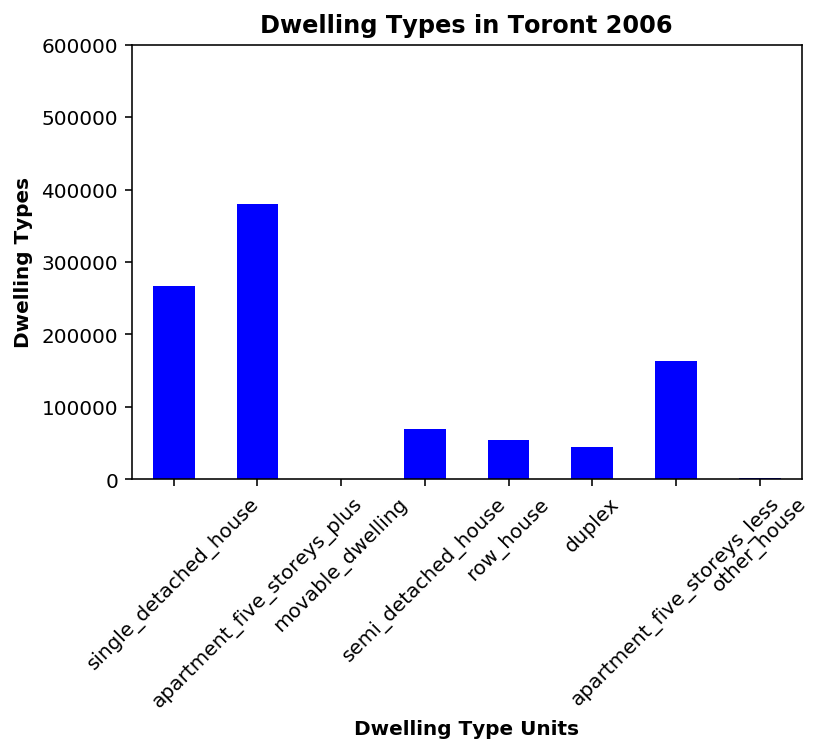
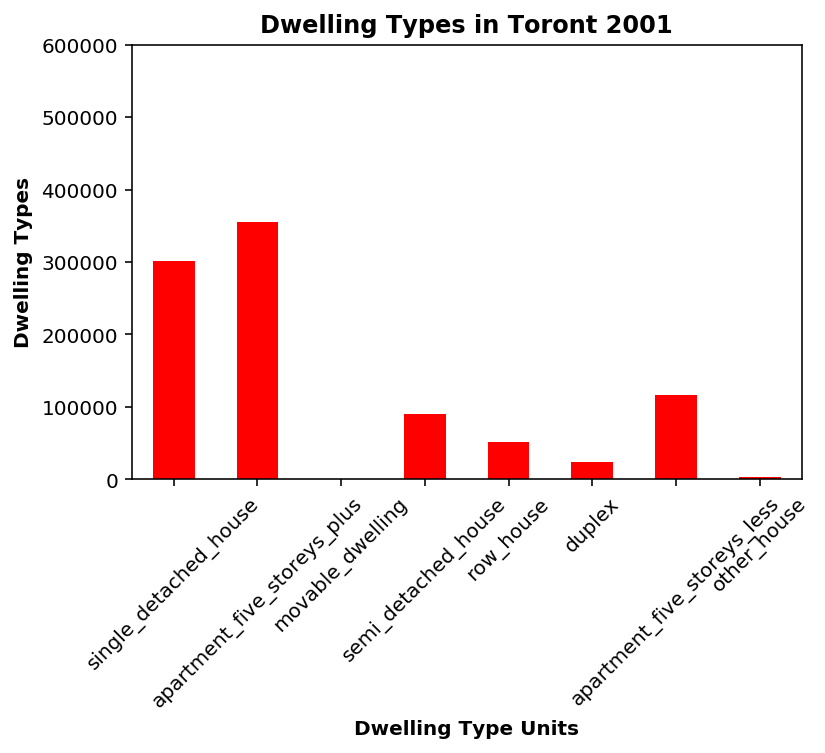
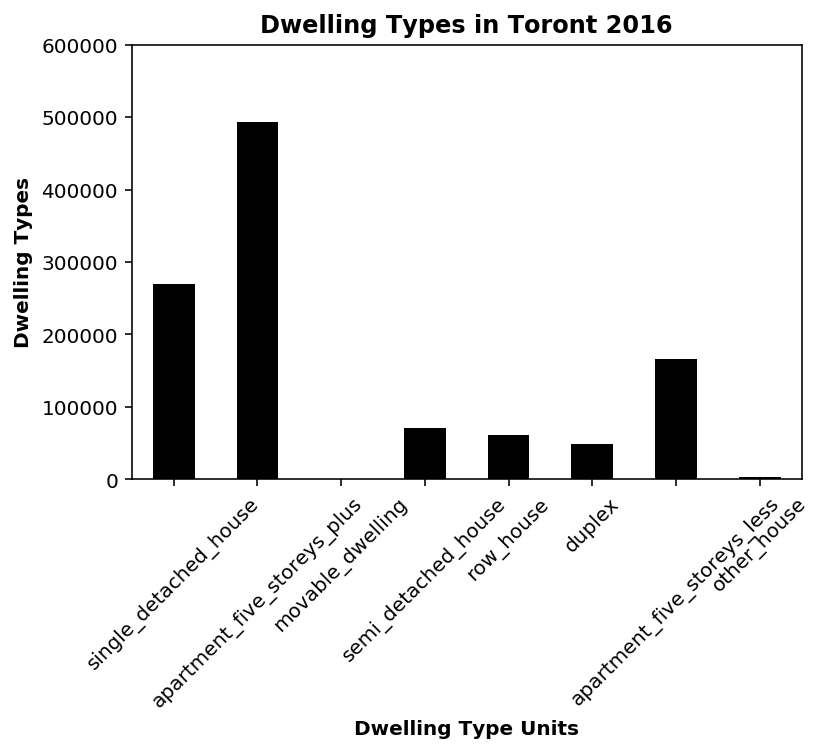
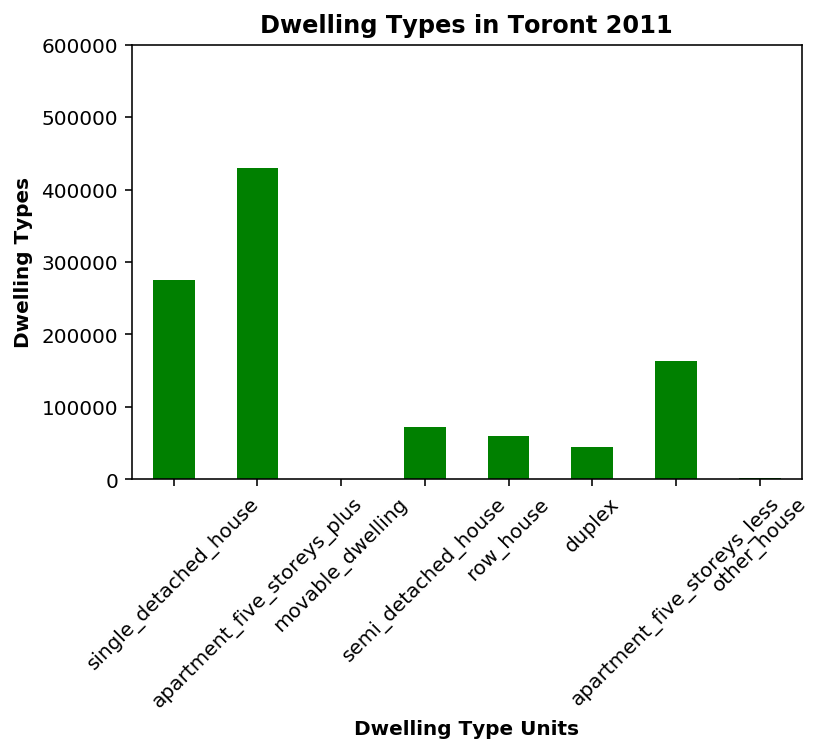
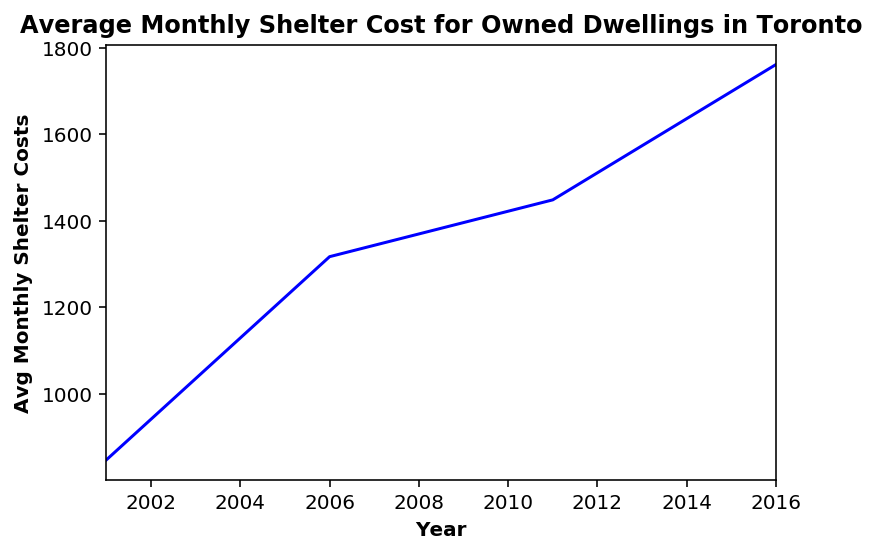
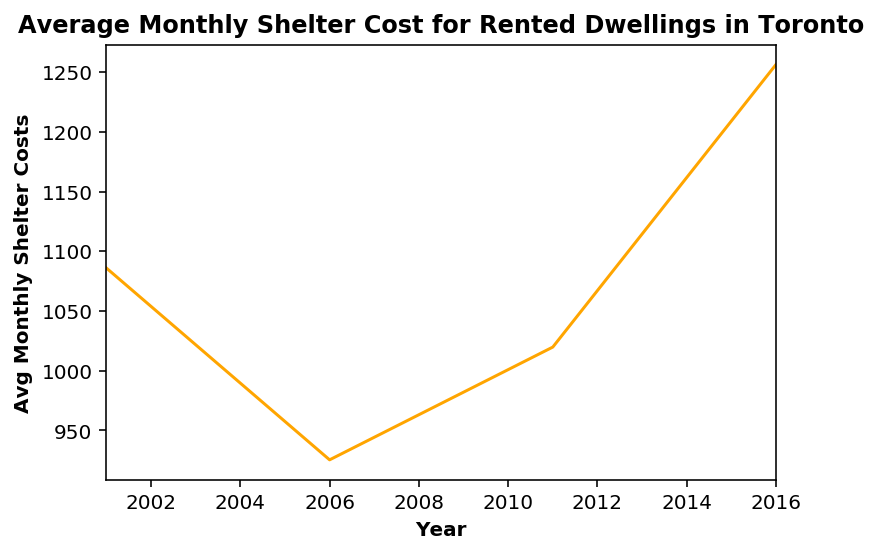
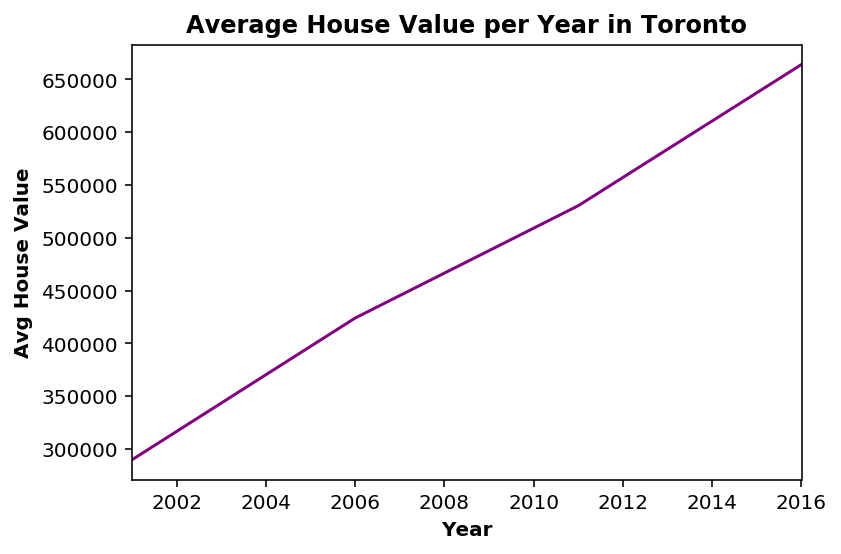

In [11]:
#Will make your dashboard discoverable to Bokeh server.
real_estate_dashboard.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [12]:
#neighbourhood_map().show()

In [13]:
#create_bar_chart(data, title, xlabel, ylabel, color)

# # Bar chart for 2001
#create_bar_chart(dwellings_grp_df.iloc[0, :], 'Dwelling Types in Toront 2001', 'Dwelling Type Units', 'Dwelling Types', 'red')

# # # Bar chart for 2006
#create_bar_chart(dwellings_grp_df.iloc[1, :], 'Dwelling Types in Toront 2006', 'Dwelling Type Units', 'Dwelling Types', 'blue')

# # # Bar chart for 2011
# create_bar_chart(dwellings_grp_df.iloc[2, :], 'Dwelling Types in Toront 2011', 'Dwelling Type Units', 'Dwelling Types', 'orange')

# # # Bar chart for 2016
# create_bar_chart(dwellings_grp_df.iloc[3, :], 'Dwelling Types in Toront 2016', 'Dwelling Type Units', 'Dwelling Types', 'magenta')


In [14]:
# cost_owned_df = to_data[["shelter_costs_owned", "shelter_costs_rented"]]
# cost_owned_grp_df = cost_owned_df.groupby(['year']).mean()
# cost_owned_grp_df

# # # Line chart for owned dwellings
# create_line_chart(cost_owned_grp_df.iloc[:, 0], "Average Monthly Shelter Cost for Owned Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "blue")

# # # Line chart for rented dwellings
# create_line_chart(cost_owned_grp_df.iloc[:, 1], "Average Monthly Shelter Cost for Rented Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "orange")

In [15]:
#average_house_value(to_data)

In [16]:
#average_value_by_neighbourhood()

In [17]:
#number_dwelling_types()

In [18]:
#average_house_value_snapshot()

In [19]:
#top_most_expensive_neighbourhoods()

In [20]:
# exp_neighbourhoods_df = to_data[["neighbourhood", "shelter_costs_owned"]].reset_index()

# df_2001 = exp_neighbourhoods_df.loc[exp_neighbourhoods_df['year'] == 2001].sort_values('shelter_costs_owned', ascending=False)
# df_2001_top10 = df_2001.iloc[0:10, :]


# df_2006 = exp_neighbourhoods_df.loc[exp_neighbourhoods_df['year'] == 2006].sort_values('shelter_costs_owned', ascending=False)
# df_2006_top10 = df_2006.iloc[0:10, :]

# df_2011 = exp_neighbourhoods_df.loc[exp_neighbourhoods_df['year'] == 2011].sort_values('shelter_costs_owned', ascending=False)
# df_2011_top10 = df_2011.iloc[0:10, :]


# df_2016 = exp_neighbourhoods_df.loc[exp_neighbourhoods_df['year'] == 2016].sort_values('shelter_costs_owned', ascending=False)
# df_2016_top10 = df_2016.iloc[0:10, :]

# df_years_merged = pd.concat((df_2001_top10, df_2006_top10, df_2011_top10, df_2016_top10), axis=0, join='inner')

# sunburts_cost_analysis()